**PIPELINE**:

**Train**: 

1. $r_t = r_0 + c_1 t$

2. $c_1(\phi, \mu) \approx p_0(\mu) + p_1(\mu)\phi  + p_2(\mu) \phi^2 + \cdots$

3. New mapping: either $g: \mu \rightarrow c_1$ or $g: \mu \rightarrow (p_0, p_1, p_2, \cdots)$

**Test**:
1. Sample $\mu^{\ast}$

2. Push through $g$, get $c_1$

3. $r_t^{\ast} = r_0^{\ast} + c_1^{\ast} t$

4. Predictive uncertainty? 


5. Inference on $\mu$?? $\color{red}{\text{(details to follow)}}$

**Transfer**

(need some more reliable edge data for this, but using some limited samples)

1. Specify $r_0$

2. Specify $\mu$

3. Assume covariate shift i.e. shift in $\phi$ and $\mu$ (tricky for $\phi$? $\phi$ actually depends on $\mu$? or at least on orientation!) - can we make this conditional on $\phi$ and reframe?

4. Reweigh samples

5. Generate new predictions

Same concept as previous notebook, but trying to learn an approximate instead of exact GP to avoid memory intensive calculation.

In [2]:
import numpy as np
import pandas as pd

In [3]:
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import tqdm
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

from sklearn.preprocessing import StandardScaler
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

from matplotlib import pyplot as plt

In [6]:
import re
import os

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
%matplotlib inline

In [9]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [10]:
import edge_utils as edut

Load data

In [11]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [12]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 160, 278)

In [13]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [14]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)

Least Squares Fit (don't need non-linear because of independence of $k$ and $\tau$.

In [15]:
def getRValuesAllSims(edge_data_matrix):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [16]:
# we are removing some data where the edge detection is not necessarily super reliable.
sims_to_remove = np.array([33, 39, 63, 73, 113, 128, 131, 142, 193, 218, 253, 264, 273, 312, 313, 324])

In [17]:
sd_modified = np.setdiff1d(sd_2161, sims_to_remove)

In [18]:
rd_2161 = getRValuesAllSims(ed_2161)

In [19]:
data_dim = rd_2161.shape[1]
data_dim

160

In [20]:
# param_dim = cme_params_to_augment.shape[1]
# param_dim

In [21]:
# augmented_r = np.zeros((rd_2161.shape[0], data_dim + param_dim, rd_2161.shape[2]))
# augmented_r[:, :(data_dim), :] = rd_2161
# for iii in range(rd_2161.shape[2]):
#     augmented_r[:, (data_dim):, iii] = cme_params_to_augment[iii, :]

In [22]:
def lin_velocity_func(x, t, y):
    return x[0] * t - y

In [23]:
def gen_velocities(t, c1):
    return c1 * t

In [24]:
from scipy.optimize import least_squares

In [25]:
def fit_velocity(edge_data_matrix, 
                 sim_data, simIdx=0, 
                theta=np.linspace(-31, 82, 160), 
                lsq_loss="soft_l1",
                fscale=0.1,
                x0 = [0.00517464 * 400]):
    """
    for a chosen sim ID, fit least squares to all valid times in edge data, varying with position angle.
    return matrix of size (n_theta x n_params), here n_params = 1
    """
    
    ntheta = len(theta)
    
    simID = sim_data[simIdx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=simIdx)
    
    r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=simIdx, minStartIdx=0)
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_time_idx = np.array([np.where(all_times == i)[0][0] for i in valid_times])
    
    # rescale valid_times
    # convert time to hours from minutes
    #     valid_times_hrs = valid_times / 60
    valid_times_rs = (valid_times - tMin) / (tMax - tMin)
    
    lsq_params = np.zeros((ntheta, 1))
    
    r_vals_valid = r_vals[valid_time_idx, :]
    
    r0 = r_vals_valid[0, :]
    
    
    t_train = valid_times_rs[1:]
    r_train = r_vals_valid[1:, :] - r0
    
    r_pred = np.zeros(np.shape(r_vals_valid))
    
    r_pred[0, :] = r0
    
    for pa_idx, pa in enumerate(theta):
        res_lsq = least_squares(lin_velocity_func,
                                x0,
                                loss=lsq_loss,
                                args=(t_train, r_train[:, pa_idx]),
                                bounds=(0, np.inf),
                                verbose=0)
        
        
        lsq_params[pa_idx, :] = res_lsq.x
        r_pred[1:, pa_idx] = gen_velocities(t_train, *res_lsq.x) + r0[pa_idx]
    
    return lsq_params, r_pred, r_vals_valid

In [26]:
# params_s0, r_pred_s0, r_vals_s0 = fit_velocity(ed_2161, sd_2161, simIdx=0, lsq_loss="linear")

In [27]:
# params_s0

In [28]:
orig_sd_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_modified])
orig_sd_idx.shape

(262,)

In [29]:
# c1_params = np.zeros((160, 1, len(sd_modified)))
# for i in range(len(sd_modified)):
#     params_sheeley, r_pred_sheeley, r_vals_sheeley = fit_velocity(ed_2161, 
#                                                                   sd_2161, 
#                                                                   simIdx=orig_sd_idx[i], 
#                                                                   lsq_loss="soft_l1")
    
#     c1_params[:, :, i] = params_sheeley
# # #     edut.plotTrainPredData1Model(r_vals_sheeley, r_pred_sheeley, ed_2161, sd_modified, simIdx=i, 
# # #                                   savefig=True,
# # #                                   savedir="./linear_velocity_fit_all_sims"
# # #                                  )

In [30]:
# np.save("c1_least_squares_correct.npy", c1_params)

In [31]:
c1_params = np.load("c1_least_squares_correct.npy")

In [32]:
def getDataForLinearFit(edge_data_matrix, 
                 sim_data, simIdx=0, 
                theta=np.linspace(-31, 82, 160)):
    ntheta = len(theta)
    
    simID = sim_data[simIdx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=simIdx)
    
    r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=simIdx, minStartIdx=0)
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_time_idx = np.array([np.where(all_times == i)[0][0] for i in valid_times])
    
    # rescale valid_times
    # convert time to hours from minutes
    #     valid_times_hrs = valid_times / 60
    valid_times_rs = (valid_times - tMin) / (tMax - tMin)
    
    r_vals_valid = r_vals[valid_time_idx, :]

    r0 = r_vals_valid[0, :]


    t_train = valid_times_rs[1:]
    r_train = r_vals_valid[1:, :] - r0

    return r_train, t_train

In [33]:
r_train203, t_train203 = getDataForLinearFit(ed_2161, sd_2161, simIdx=159)

In [34]:
# for sidx, sid in enumerate(sd_modified):
#     plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, sidx], label="")
#     plt.xlabel("phi")
#     plt.xlim((-31, 82))
#     plt.title("Sim {} c1".format(sid))
#     plt.savefig(os.path.join("c1_figs", "Sim_{:03d}_c1.png".format(sid)))
#     plt.close()

Text(0.5, 1.0, 'c1 selected')

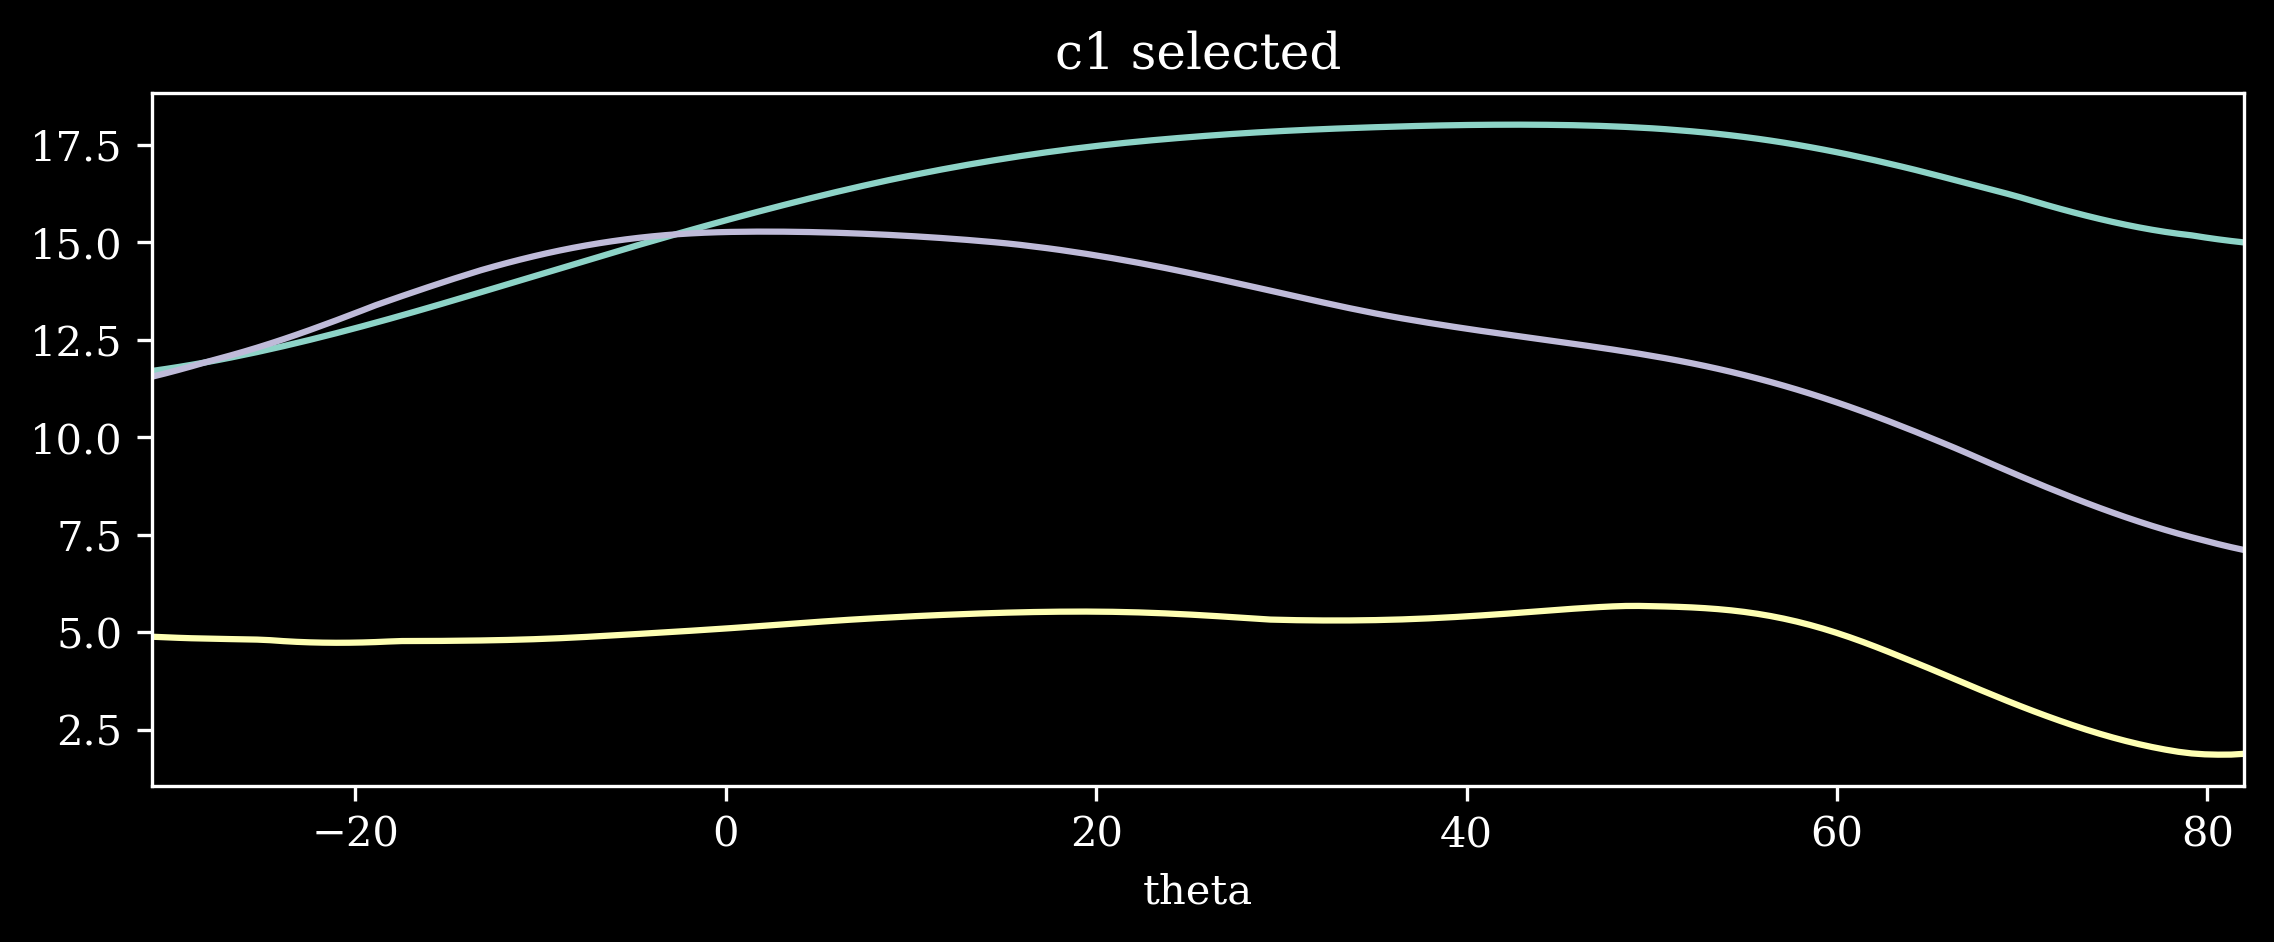

In [35]:
plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, 0], label="")
plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, 1], label="")
plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, 20], label="")
plt.xlabel("theta")
plt.xlim((-31, 82))
plt.title("c1 selected")

#### Load CME Parameters

In [36]:
cme_params = pd.read_csv("./restarts_CR2161.csv")
cme_params.head()

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,restartdir,realization
0,0.58375,22.526622,0.682075,204.725,1,4,4
1,0.52625,6.919483,0.519179,164.225,1,4,4
2,0.72625,5.087500,0.662022,233.975,1,4,4
3,0.36125,18.360770,0.420743,200.675,-1,4,4
4,0.69125,8.127120,0.735101,184.925,1,4,4


In [37]:
bg_params = pd.read_csv("./backgrounds_CR2161.csv")

In [38]:
unique_bg = cme_params.restartdir.unique()
unique_bg

array([ 4, 12])

In [39]:
cme_param_bg_idx = []
for bg in unique_bg:
    cme_param_bg_idx.append(np.array((cme_params.restartdir == bg).to_list()))

In [40]:
bg_params_to_insert = np.zeros((cme_params.shape[0], bg_params.shape[1]))
for bg_idx, bg in enumerate(unique_bg):
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 0] = bg_params.FactorB0[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 1] = bg_params.PoyntingFluxPerBSi[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 2] = bg_params.LperpTimesSqrtBSi[bg - 1]

cme_params["FactorB0"] = pd.Series(bg_params_to_insert[:, 0])
cme_params["PoyntingFluxPerBSi"] = pd.Series(bg_params_to_insert[:, 1])
cme_params["LperpTimesSqrtBSi"] = pd.Series(bg_params_to_insert[:, 2])
cme_params["SimID"] = pd.Series(np.linspace(31, 330, 300))
sim_idx_successful = sd_2161 - 30 - 1
sim_idx_to_drop = np.setdiff1d(np.linspace(0, 299, 300), sim_idx_successful).astype(int).tolist()


cme_params.drop(["restartdir"], axis=1, inplace=True)
cme_params.drop(sim_idx_to_drop, inplace=True)
cme_params.drop(["SimID"], axis=1, inplace=True)
cme_params

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.58375,22.526622,0.682075,204.725,1,4,0.8010,378833.7,147856.5
1,0.52625,6.919483,0.519179,164.225,1,4,0.8010,378833.7,147856.5
2,0.72625,5.087500,0.662022,233.975,1,4,0.8010,378833.7,147856.5
3,0.36125,18.360770,0.420743,200.675,-1,4,0.8010,378833.7,147856.5
4,0.69125,8.127120,0.735101,184.925,1,4,0.8010,378833.7,147856.5
...,...,...,...,...,...,...,...,...,...
294,0.73750,15.331483,0.721367,170.750,-1,5,1.3016,304514.4,283042.3
295,0.36250,32.665259,0.436133,197.750,-1,5,1.3016,304514.4,283042.3
296,0.46250,26.757500,0.443711,224.750,1,5,1.3016,304514.4,283042.3
297,0.76250,16.930533,0.874492,215.750,-1,5,1.3016,304514.4,283042.3


In [41]:
cme_p_min = cme_params.min()
cme_p_min.BStrength = 4.4516
cme_p_min.Radius = 0.3
cme_p_min.OrientationCme = 155
cme_p_min.iHelicity = -1
cme_p_min.ApexHeight = 0.2625
cme_p_min.realization = 1
cme_p_min.FactorB0 = 0.54
cme_p_min.PoyntingFluxPerBSi = 0.3e6
cme_p_min.LperpTimesSqrtBSi = 0.3e5

cme_p_min

Radius                     0.3000
BStrength                  4.4516
ApexHeight                 0.2625
OrientationCme           155.0000
iHelicity                 -1.0000
realization                1.0000
FactorB0                   0.5400
PoyntingFluxPerBSi    300000.0000
LperpTimesSqrtBSi      30000.0000
dtype: float64

In [42]:
cme_p_max = cme_params.max()
cme_p_max.BStrength = 47.4833
cme_p_max.Radius = 0.8
cme_p_max.OrientationCme = 245
cme_p_max.iHelicity = 1
cme_p_max.ApexHeight = 1
cme_p_max.realization = 12
cme_p_max.FactorB0 = 2.7
cme_p_max.PoyntingFluxPerBSi = 1.1e6
cme_p_max.LperpTimesSqrtBSi = 3e5

cme_p_max

Radius                8.000000e-01
BStrength             4.748330e+01
ApexHeight            1.000000e+00
OrientationCme        2.450000e+02
iHelicity             1.000000e+00
realization           1.200000e+01
FactorB0              2.700000e+00
PoyntingFluxPerBSi    1.100000e+06
LperpTimesSqrtBSi     3.000000e+05
dtype: float64

In [43]:
cme_params_norm = (cme_params - cme_p_min) / (cme_p_max - cme_p_min)
cme_params_norm

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506
...,...,...,...,...,...,...,...,...,...
294,0.8750,0.252834,0.622193,0.1750,0.0,0.363636,0.352593,0.005643,0.937194
295,0.1250,0.655648,0.235434,0.4750,0.0,0.363636,0.352593,0.005643,0.937194
296,0.3250,0.518360,0.245710,0.7750,1.0,0.363636,0.352593,0.005643,0.937194
297,0.9250,0.289994,0.829820,0.6750,0.0,0.363636,0.352593,0.005643,0.937194


In [44]:
cme_params_to_augment = cme_params_norm.to_numpy()
cme_params_to_augment.shape

(278, 9)

**Split into train and test for GPs**

In [45]:
from numpy.random import Generator, PCG64
rng = np.random.default_rng(2023)

nTrain = int(np.floor(0.6 * len(sd_modified)))
nCalib = int(np.floor(0.2 * len(sd_modified)))
nTest = len(sd_modified) - nTrain - nCalib

nTrain, nTest, nCalib

(157, 53, 52)

In [46]:
len(sd_modified)

262

In [47]:
orig_sd_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_modified])

In [48]:
sd_train = np.sort(rng.choice(sd_modified, nTrain, replace=False))
sd_test_calib = np.setdiff1d(sd_modified, sd_train)
sd_calib = np.sort(rng.choice(sd_test_calib, nCalib, replace=False))
sd_test = np.setdiff1d(sd_test_calib, sd_calib)

sd_test, sd_calib

(array([ 36,  41,  43,  48,  50,  70,  79,  81,  85,  89,  92,  94, 101,
        114, 118, 119, 135, 140, 141, 151, 158, 164, 168, 169, 172, 174,
        178, 180, 188, 200, 204, 206, 211, 213, 214, 224, 230, 240, 243,
        246, 251, 254, 259, 261, 263, 267, 278, 288, 292, 307, 311, 320,
        328]),
 array([ 31,  35,  44,  46,  56,  61,  76,  95,  98, 105, 122, 123, 127,
        129, 143, 144, 146, 147, 153, 159, 175, 190, 194, 197, 205, 215,
        225, 231, 236, 239, 248, 249, 252, 255, 257, 258, 269, 274, 279,
        281, 284, 294, 298, 299, 302, 305, 306, 314, 316, 318, 319, 321]))

In [49]:
train_sd_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_train])
test_sd_idx  = np.array([np.where(sd_2161 == i)[0][0] for i in sd_test])

In [50]:
train_sd_idx_modified = np.array([np.where(sd_modified == i)[0][0] for i in sd_train])

In [51]:
test_sd_idx_modified = np.array([np.where(sd_modified == i)[0][0] for i in sd_test])

#### Process data

In [52]:
theta_grid_scaled = (theta_grid[0::2] - theta_grid[0])/(theta_grid[-1] - theta_grid[0])

In [53]:
theta_repeat = np.tile(theta_grid_scaled, len(train_sd_idx))

Check indexing

In [54]:
train_x_raw = cme_params_to_augment[train_sd_idx, :]
test_x_raw = cme_params_to_augment[test_sd_idx, :]

In [55]:
# train_x_raw.shape

In [56]:
# train_x_repeat = np.repeat(train_x_raw, len(theta_grid_scaled), axis=0)
# train_x_repeat.shape

In [57]:
# test_x_repeat = np.repeat(test_x_raw, len(theta_grid_scaled), axis=0)
# test_x_repeat.shape

In [58]:
# train_x_final = np.c_[theta_repeat, train_x_repeat]

In [59]:
# train_x_final.shape

In [60]:
# train_x_torch = torch.tensor(np.float32(train_x_final)).to(device)

In [61]:
# test_x_final = np.c_[np.tile(theta_grid_scaled, len(test_sd_idx)), test_x_repeat]

In [62]:
# test_x_final.shape

In [63]:
# test_x_torch = torch.tensor(np.float32(test_x_final)).to(device)

In [64]:
# c1_params_2d = np.squeeze(c1_params)

In [65]:
# train_y = c1_params_2d[0::2, train_sd_idx_modified].T.flatten()
# train_y.shape

In [66]:
# test_y = c1_params_2d[0::2, test_sd_idx_modified].T.flatten()
# test_y.shape

In [67]:
# train_y_torch = torch.tensor(np.float32(train_y)).to(device)

In [68]:
# train_y_torch.shape

In [69]:
# test_y_torch = torch.tensor(np.float32(test_y)).to(device)

### Fit Polynomials

Learn polynomial mapping between $c_1$ and flux rope parameters, then construct a GP using a small number of $c_1$ values and parameters. Alternately, learn the GP or a regular interpolator between the coefficients of the fitted polynomials and the flux rope parameters (eliminate dependence on position angle as an additional parameter)

The previous data processing applies to GP. Here we (probably) don't need to `tile` for position angle! - we need to see what sort of assumptions we make about the coefficients though.

In [70]:
# train_x_final, test_x_final
# train_y, test_y

In [71]:
c1_params.shape

(160, 1, 262)

In [72]:
c1_params_final = np.squeeze(c1_params)

In [73]:
c1_params_train = c1_params_final[:, train_sd_idx_modified].T
c1_params_test  = c1_params_final[:, test_sd_idx_modified].T

c1_params_train.shape, c1_params_test.shape

((157, 160), (53, 160))

In [74]:
train_x_raw.shape

(157, 9)

In [75]:
test_x_raw.shape

(53, 9)

In [76]:
fit_deg = 6

In [77]:
polynomial_coeffs = np.zeros((fit_deg + 1, c1_params_train.shape[0]))

In [78]:
for i in range(c1_params_train.shape[0]):
    polynomial_coeffs[:, i] = np.polyfit(theta_grid, c1_params_train[i, :], deg=fit_deg) 

In [79]:
# np.polyfit(theta_grid, c1_params_train[1, :], deg=fit_deg, full=True, cov=True)

In [80]:
polynomial_coeffs.shape

(7, 157)

In [81]:
polynomial_coeffs_test = np.zeros((fit_deg + 1, c1_params_test.shape[0]))

In [82]:
for i in range(c1_params_test.shape[0]):
    polynomial_coeffs_test[:, i] = np.polyfit(theta_grid, c1_params_test[i, :], deg=fit_deg) 

In [83]:
polynomial_coeffs_test.shape

(7, 53)

In [84]:
# plot polynomial coefficients p0 p1 p2 p3

# fig = plt.figure()
# for i in range(6):
#     plt.subplot(2, 3, i + 1)
#     plt.tight_layout()
#     plt.scatter(np.linspace(1, 157, 157), polynomial_coeffs[i, :])
#     plt.xlabel("Sim ID")
#     if i == 0:
#         plt.ylabel("Coefficient")
#     plt.title("p{}".format(5 - i))


In [85]:
theta_grid_scaled.shape

(80,)

In [86]:
pc1 = polynomial_coeffs[:, 0]
pc1

array([ 2.42376932e-10, -3.63726230e-08,  1.11267036e-06,  2.51640353e-05,
       -1.14732248e-03,  1.33934075e-02,  5.22663017e+00])

In [87]:
def getPredPolyFit(poly_coeffs, x):
    poly_sum = 0
    deg = len(poly_coeffs) - 1
    for i in range(len(poly_coeffs)):
        poly_sum = poly_sum + poly_coeffs[i] * (x**(deg - i))
        
    return poly_sum

In [88]:
# # plot to show fit (with selected points)

# for i in range(len(sd_train)):
#     plt.plot(np.linspace(-31, 82, 160), c1_params_train[i, :], label="true")
#     plt.plot(theta_grid[0::2], getPredPolyFit(polynomial_coeffs[:, i], theta_grid[0::2]), linestyle="--", label="fit")
#     plt.xlabel("phi")
#     plt.ylabel("c1")
#     plt.xlim((-31, 82))
#     plt.legend()
#     plt.title("Sim {}".format(sd_train[i]))
#     plt.savefig(os.path.join("c1_polynomial_fit", "sim_{:03d}.png".format(sd_train[i])))
#     plt.close()

_Interpolate polynomial coefficients as a function of flux rope parameters_ - this is _probably_ better. The dependence on position angle is not easy to account for as we saw the last time, and if we just take a few select angles, the interpolation especially of GP-style methods in between them may not be reliable.

this is a safer 2 stage method. once we have predicted coefficients with confidence intervals, use them to generate predictions of $c_1$.

**Multi-task GP** - correlated output dimensions, each output "task" (in our case, each polynomial coefficient) shares the same inputs $\mu$.

Reference: [GPyTorch Docs](https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html)

In [89]:
import scipy.interpolate

import torch
import gpytorch

In [90]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, tx, ty, lkl):
        super(MultitaskGPModel, self).__init__(tx, ty, lkl)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=7
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=7, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [91]:
train_x_torch_final = torch.tensor(np.float32(train_x_raw)).to(device)

In [92]:
train_x_torch_final.shape

torch.Size([157, 9])

In [93]:
train_y_torch_final = torch.tensor(np.float32(polynomial_coeffs.T)).to(device)

In [94]:
train_y_torch_final.shape

torch.Size([157, 7])

In [95]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=7)
model = MultitaskGPModel(train_x_torch_final, train_y_torch_final, likelihood)

In [96]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [97]:
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

In [98]:
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [99]:
training_iterations = 1000

In [100]:
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x_torch_final)
    loss = -mll(output, train_y_torch_final)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/1000 - Loss: 2.157
Iter 2/1000 - Loss: 2.038
Iter 3/1000 - Loss: 1.942
Iter 4/1000 - Loss: 1.858
Iter 5/1000 - Loss: 1.783
Iter 6/1000 - Loss: 1.714
Iter 7/1000 - Loss: 1.649
Iter 8/1000 - Loss: 1.586
Iter 9/1000 - Loss: 1.524
Iter 10/1000 - Loss: 1.462
Iter 11/1000 - Loss: 1.400
Iter 12/1000 - Loss: 1.338
Iter 13/1000 - Loss: 1.275
Iter 14/1000 - Loss: 1.213
Iter 15/1000 - Loss: 1.151
Iter 16/1000 - Loss: 1.088
Iter 17/1000 - Loss: 1.025
Iter 18/1000 - Loss: 0.961
Iter 19/1000 - Loss: 0.900
Iter 20/1000 - Loss: 0.840
Iter 21/1000 - Loss: 0.782
Iter 22/1000 - Loss: 0.725
Iter 23/1000 - Loss: 0.669
Iter 24/1000 - Loss: 0.616
Iter 25/1000 - Loss: 0.565
Iter 26/1000 - Loss: 0.515
Iter 27/1000 - Loss: 0.465
Iter 28/1000 - Loss: 0.416
Iter 29/1000 - Loss: 0.368
Iter 30/1000 - Loss: 0.320
Iter 31/1000 - Loss: 0.273
Iter 32/1000 - Loss: 0.225
Iter 33/1000 - Loss: 0.178
Iter 34/1000 - Loss: 0.130
Iter 35/1000 - Loss: 0.083
Iter 36/1000 - Loss: 0.035
Iter 37/1000 - Loss: -0.014
Iter 38/1

Iter 297/1000 - Loss: -2.318
Iter 298/1000 - Loss: -2.318
Iter 299/1000 - Loss: -2.319
Iter 300/1000 - Loss: -2.318
Iter 301/1000 - Loss: -2.318
Iter 302/1000 - Loss: -2.317
Iter 303/1000 - Loss: -2.313
Iter 304/1000 - Loss: -2.304
Iter 305/1000 - Loss: -2.282
Iter 306/1000 - Loss: -2.283
Iter 307/1000 - Loss: -2.284
Iter 308/1000 - Loss: -2.313
Iter 309/1000 - Loss: -2.262
Iter 310/1000 - Loss: -2.296
Iter 311/1000 - Loss: -2.206
Iter 312/1000 - Loss: -2.283
Iter 313/1000 - Loss: -2.211
Iter 314/1000 - Loss: -2.120
Iter 315/1000 - Loss: -2.170
Iter 316/1000 - Loss: -2.244
Iter 317/1000 - Loss: -2.218
Iter 318/1000 - Loss: -2.199
Iter 319/1000 - Loss: -2.220
Iter 320/1000 - Loss: -2.248
Iter 321/1000 - Loss: -2.272
Iter 322/1000 - Loss: -2.252
Iter 323/1000 - Loss: -2.251
Iter 324/1000 - Loss: -2.264
Iter 325/1000 - Loss: -2.285
Iter 326/1000 - Loss: -2.248
Iter 327/1000 - Loss: -2.175
Iter 328/1000 - Loss: -2.260
Iter 329/1000 - Loss: -2.238
Iter 330/1000 - Loss: -2.213
Iter 331/1000 

Iter 600/1000 - Loss: -2.327
Iter 601/1000 - Loss: -2.327
Iter 602/1000 - Loss: -2.328
Iter 603/1000 - Loss: -2.328
Iter 604/1000 - Loss: -2.328
Iter 605/1000 - Loss: -2.328
Iter 606/1000 - Loss: -2.328
Iter 607/1000 - Loss: -2.328
Iter 608/1000 - Loss: -2.327
Iter 609/1000 - Loss: -2.326
Iter 610/1000 - Loss: -2.321
Iter 611/1000 - Loss: -2.316
Iter 612/1000 - Loss: -2.309
Iter 613/1000 - Loss: -2.315
Iter 614/1000 - Loss: -2.325
Iter 615/1000 - Loss: -2.330
Iter 616/1000 - Loss: -2.323
Iter 617/1000 - Loss: -2.326
Iter 618/1000 - Loss: -2.330
Iter 619/1000 - Loss: -2.327
Iter 620/1000 - Loss: -2.329
Iter 621/1000 - Loss: -2.330
Iter 622/1000 - Loss: -2.328
Iter 623/1000 - Loss: -2.328
Iter 624/1000 - Loss: -2.318
Iter 625/1000 - Loss: -2.294
Iter 626/1000 - Loss: -2.244
Iter 627/1000 - Loss: -2.290
Iter 628/1000 - Loss: -2.270
Iter 629/1000 - Loss: -2.268
Iter 630/1000 - Loss: -2.312
Iter 631/1000 - Loss: -2.317
Iter 632/1000 - Loss: -2.289
Iter 633/1000 - Loss: -2.294
Iter 634/1000 

Iter 900/1000 - Loss: -2.327
Iter 901/1000 - Loss: -2.327
Iter 902/1000 - Loss: -2.328
Iter 903/1000 - Loss: -2.328
Iter 904/1000 - Loss: -2.328
Iter 905/1000 - Loss: -2.329
Iter 906/1000 - Loss: -2.329
Iter 907/1000 - Loss: -2.329
Iter 908/1000 - Loss: -2.329
Iter 909/1000 - Loss: -2.329
Iter 910/1000 - Loss: -2.329
Iter 911/1000 - Loss: -2.327
Iter 912/1000 - Loss: -2.318
Iter 913/1000 - Loss: -2.291
Iter 914/1000 - Loss: -2.241
Iter 915/1000 - Loss: -2.263
Iter 916/1000 - Loss: -2.248
Iter 917/1000 - Loss: -2.238
Iter 918/1000 - Loss: -2.276
Iter 919/1000 - Loss: -2.273
Iter 920/1000 - Loss: -2.253
Iter 921/1000 - Loss: -2.230
Iter 922/1000 - Loss: -2.239
Iter 923/1000 - Loss: -2.207
Iter 924/1000 - Loss: -2.179
Iter 925/1000 - Loss: -2.233
Iter 926/1000 - Loss: -2.183
Iter 927/1000 - Loss: -2.232
Iter 928/1000 - Loss: -2.137
Iter 929/1000 - Loss: -2.298
Iter 930/1000 - Loss: -2.267
Iter 931/1000 - Loss: -2.259
Iter 932/1000 - Loss: -2.301
Iter 933/1000 - Loss: -2.313
Iter 934/1000 

In [101]:
# Set into eval mode
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [102]:
test_x_torch_final = torch.tensor(np.float32(test_x_raw)).to(device)
test_y_torch_final = torch.tensor(np.float32(polynomial_coeffs_test.T)).to(device)

In [103]:
test_x_torch_final.shape, test_y_torch_final.shape

(torch.Size([53, 9]), torch.Size([53, 7]))

In [104]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x_torch_final))
    mean_pred = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

/Users/ajivani/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


In [105]:
observed_pred.stddev.shape

torch.Size([53, 7])

In [106]:
lower.shape, upper.shape

(torch.Size([53, 7]), torch.Size([53, 7]))

In [107]:
err0 = np.vstack((np.abs(lower[:, 0].numpy()), upper[:, 0].numpy()))

Text(0, 0.5, 'p6')

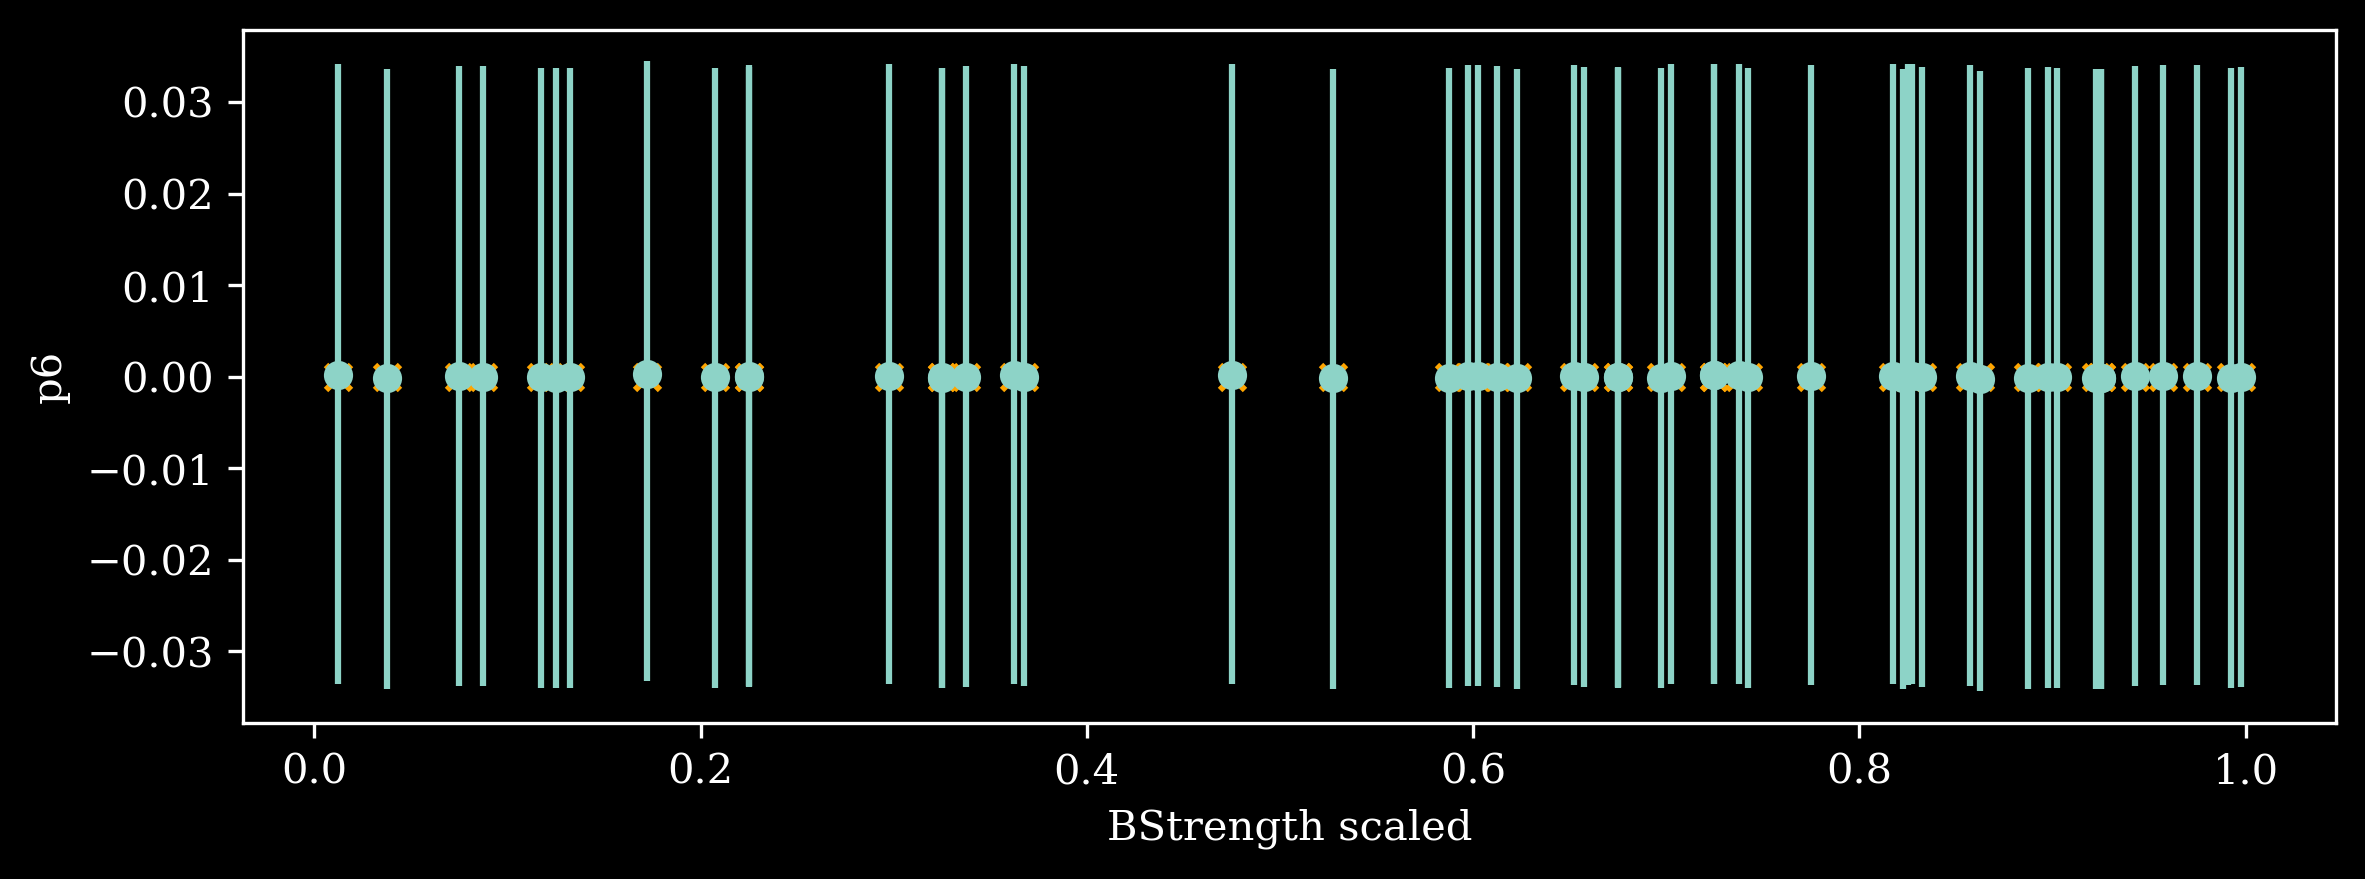

In [108]:
fig = plt.figure()
plt.errorbar(test_x_torch_final[:, 0], 
             mean_pred[:, 0], 
             yerr=err0,
             fmt="o"
            )
plt.scatter(test_x_torch_final[:, 0],
           test_y_torch_final[:, 0],
           marker='x',
           c='orange')
plt.xlabel("BStrength scaled")
plt.ylabel("p6")

Text(0, 0.5, 'p1')

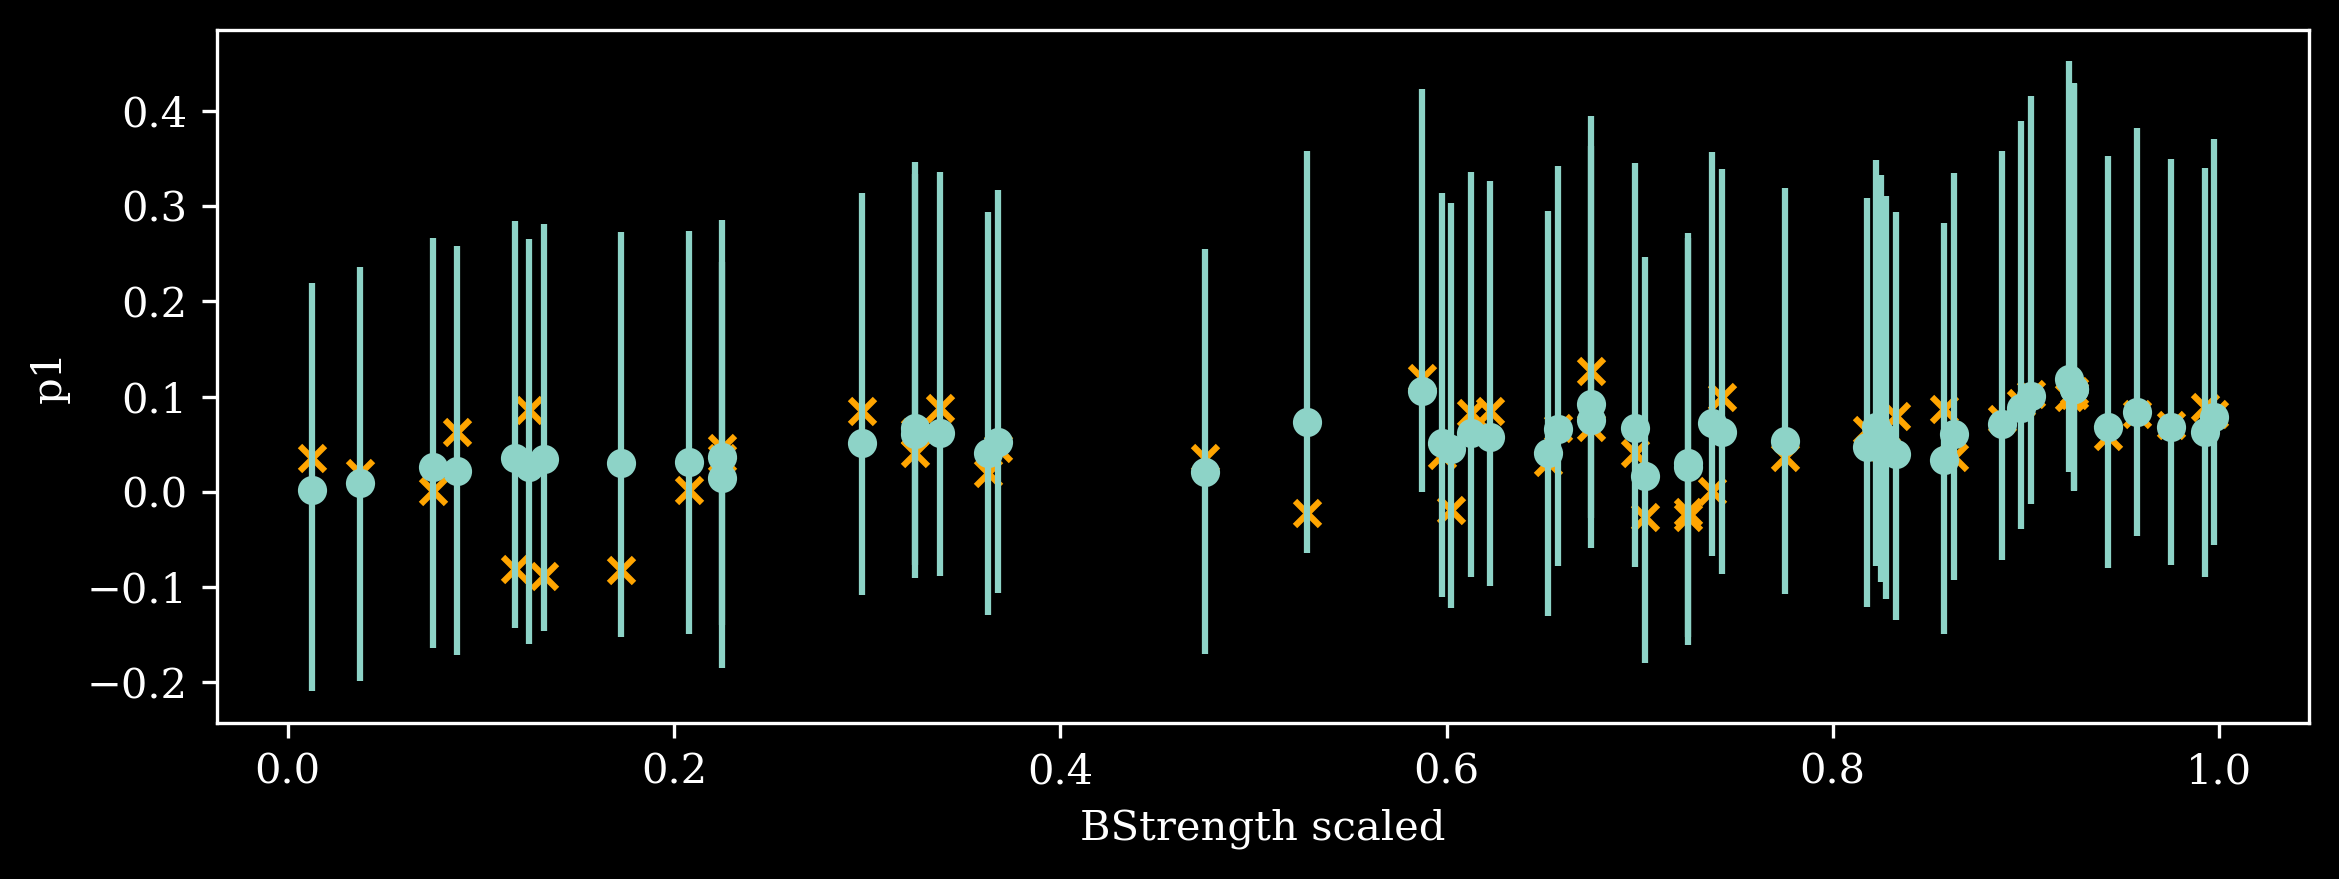

In [109]:
err_lin = np.vstack((np.abs(lower[:, -2].numpy()), upper[:, -2].numpy()))

plt.scatter(test_x_torch_final[:, 0],
           test_y_torch_final[:, -2],
           marker='x',
           c='orange')

plt.errorbar(test_x_torch_final[:, 0],
             mean_pred[:, -2], 
             yerr=err_lin,
             fmt="o"
            )

plt.xlabel("BStrength scaled")
plt.ylabel("p1")

Text(0, 0.5, 'p0')

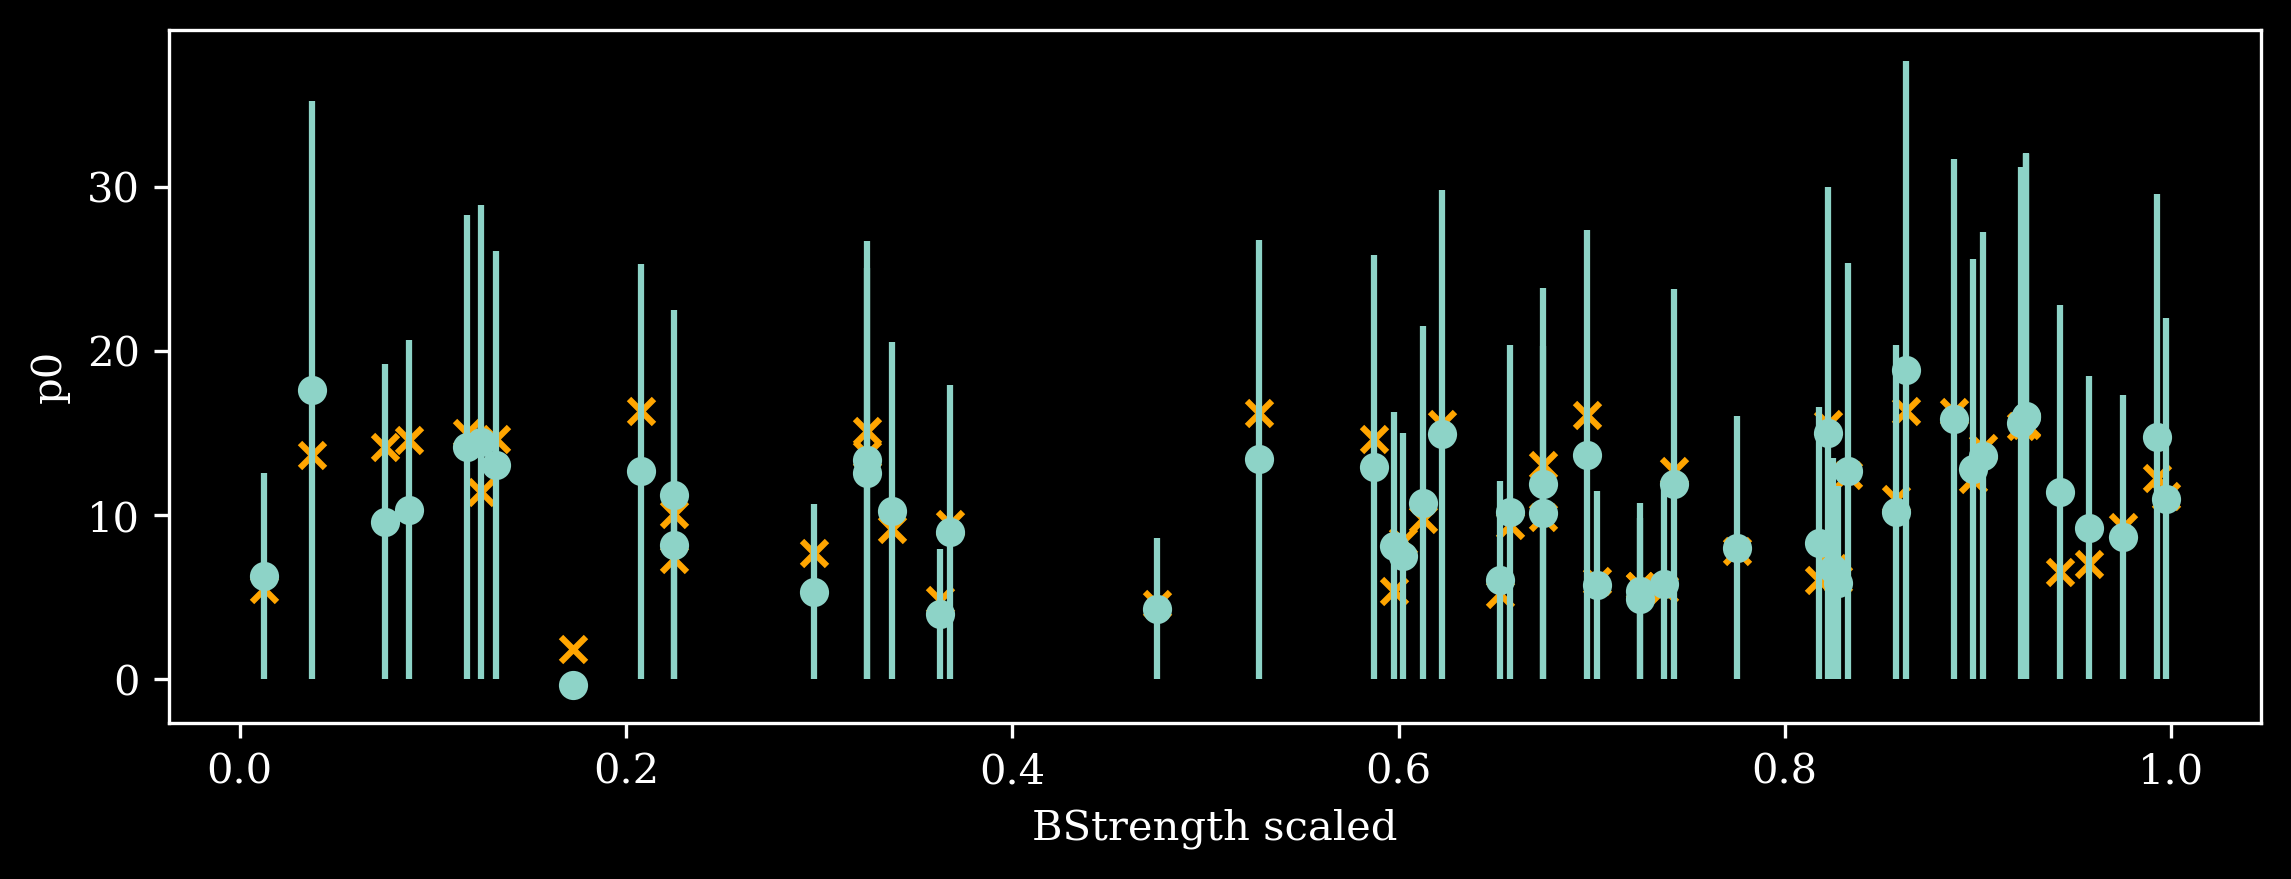

In [110]:
err_constant = np.vstack((np.abs(lower[:, -1].numpy()), upper[:, -1].numpy()))

plt.scatter(test_x_torch_final[:, 0],
           test_y_torch_final[:, -1],
           marker='x',
           c='orange')
plt.errorbar(test_x_torch_final[:, 0],
             mean_pred[:, -1], 
             yerr=err_constant,
             fmt="o"
            )
plt.xlabel("BStrength scaled")
plt.ylabel("p0")

_Results on test data with uncertainty_ first for $c_1$ (this would include only confidence from GP and not possible polynomial fitting error which could be a drawback), then the full series.

In [111]:
c1_params_test.shape

(53, 160)

Predict $c_1$ by sampling from the posterior predictive distribution of $p$

In [112]:
post_pred = torch.distributions.Normal(observed_pred.mean, observed_pred.stddev)

In [113]:
post_pred.sample().shape

torch.Size([53, 7])

Draw 1000 samples, store them in a tensor, fit $c_1$ by 6 degree polynomial and get results.

In [114]:
n_post_samples = 1000

In [115]:
p_test_samples = np.zeros((test_x_torch_final.shape[0], fit_deg + 1, n_post_samples))
for i in range(n_post_samples):
    p_test_samples[:, :, i] = post_pred.sample().numpy()

print("Generated {} samples from posterior".format(n_post_samples))

Generated 1000 samples from posterior


In [116]:
p_test_samples[0, :, 0].shape

(7,)

In [117]:
test_x_torch_final.shape

torch.Size([53, 9])

In [118]:
c1_test = np.zeros((test_x_torch_final.shape[0], 160, n_post_samples))

for i in range(n_post_samples):
    for j in range(test_x_torch_final.shape[0]):
        c1_test[j, :, i] = getPredPolyFit(p_test_samples[j, :, i], theta_grid)

print("Generated {} test velocities with {} replicates".format(test_x_torch_final.shape[0], n_post_samples))

Generated 53 test velocities with 1000 replicates


In [119]:
mean_c1 = np.mean(c1_test, axis=2)
std_c1 = np.std(c1_test, axis=2)

mean_c1.shape, std_c1.shape

((53, 160), (53, 160))

Plot a few test velocities versus the actual and examine outputs

In [120]:
c1_params_test.shape

(53, 160)

(0.0, 20.0)

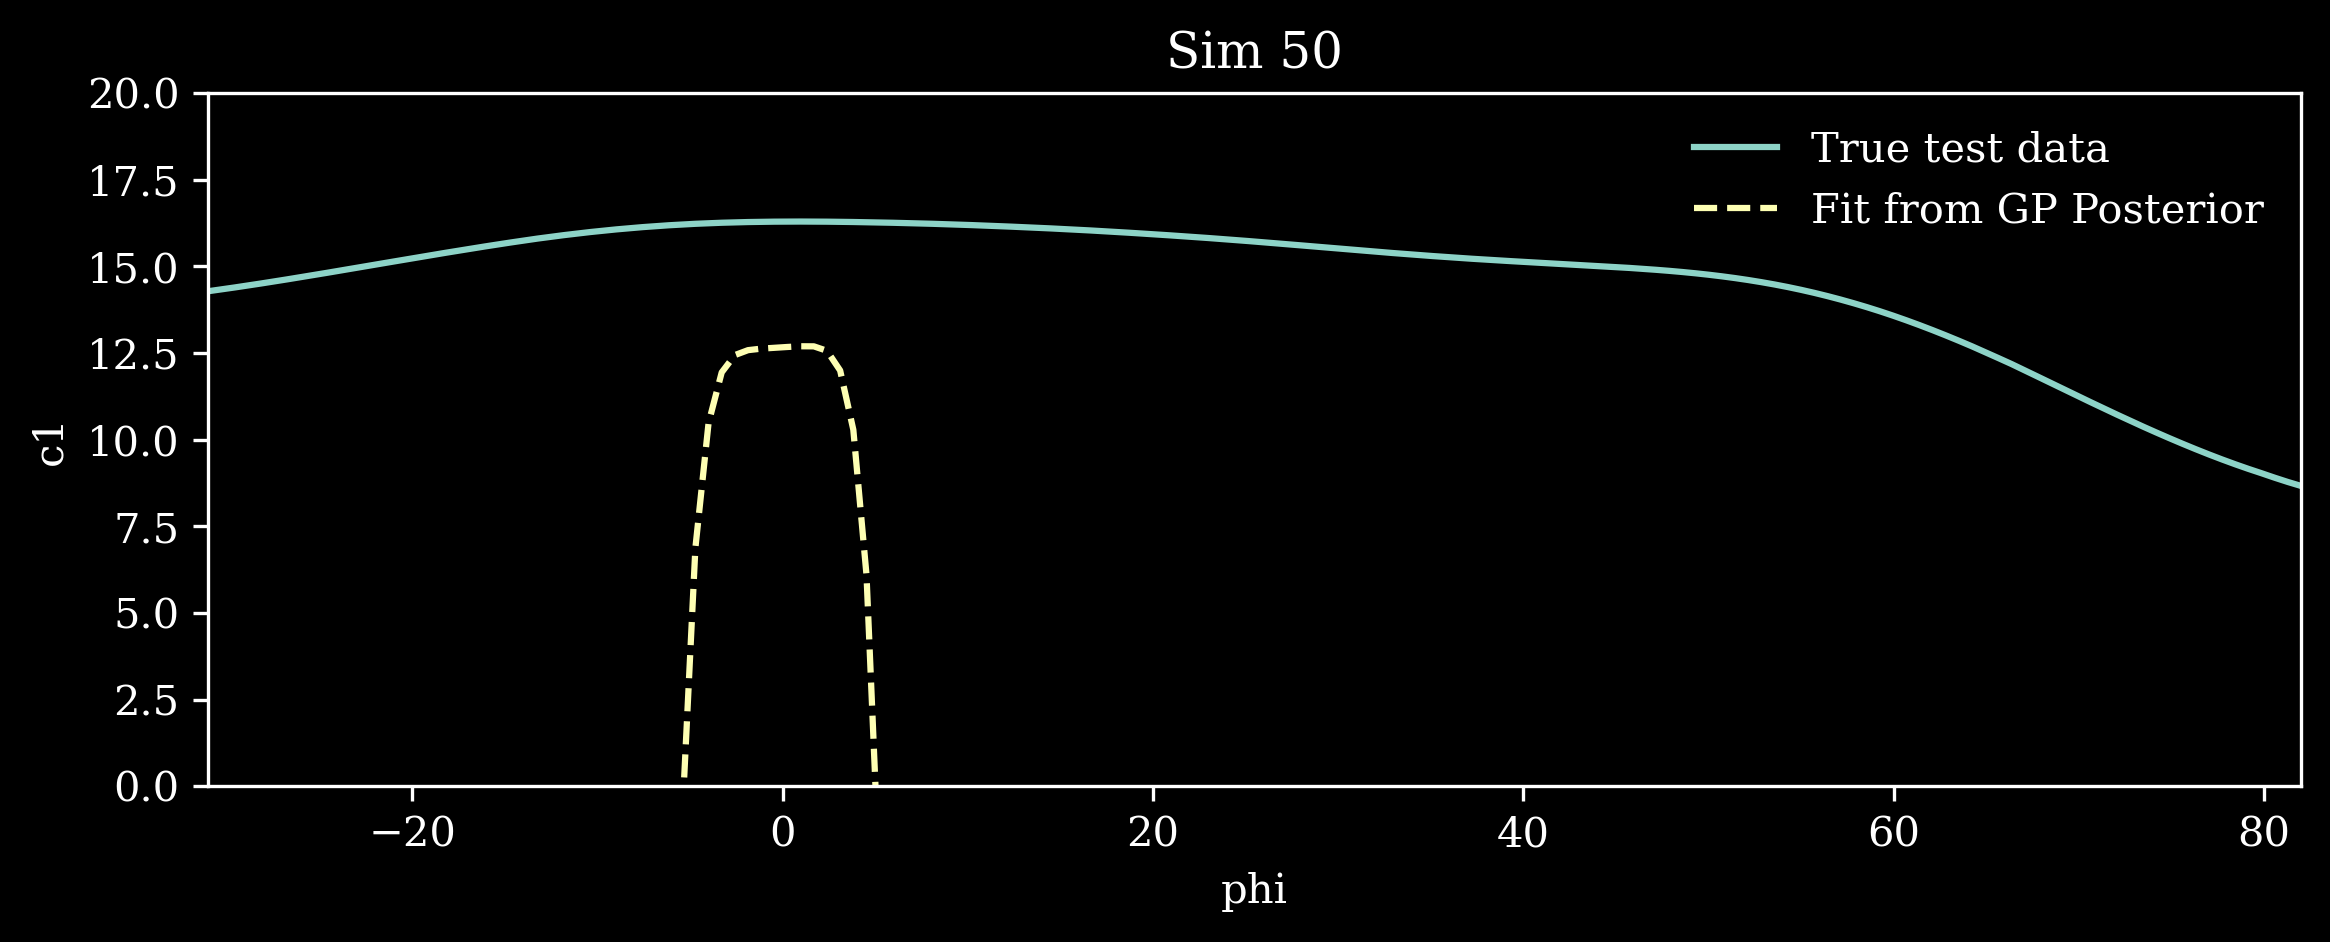

In [125]:
# for i in range(len(sd_train)):
plt.plot(theta_grid, c1_params_test[4, :], label="True test data")
plt.plot(theta_grid, mean_c1[4, :], linestyle="--", label="Fit from GP Posterior")
plt.xlabel("phi")
plt.ylabel("c1")
plt.xlim((-31, 82))
plt.legend()
plt.title("Sim {}".format(sd_test[4]))
plt.ylim((0, 20))
# plt.savefig(os.path.join("c1_polynomial_fit", "sim_{:03d}.png".format(sd_train[i])))
# plt.close()

#### Alternate: Fit GP to c1 directly.

This means position angle is also an independent parameter (but we can map it by a few points thanks to the polynomial fit)

In [130]:
theta_interp = np.linspace(-31, 82, 40)
theta_interp

array([-31.        , -28.1025641 , -25.20512821, -22.30769231,
       -19.41025641, -16.51282051, -13.61538462, -10.71794872,
        -7.82051282,  -4.92307692,  -2.02564103,   0.87179487,
         3.76923077,   6.66666667,   9.56410256,  12.46153846,
        15.35897436,  18.25641026,  21.15384615,  24.05128205,
        26.94871795,  29.84615385,  32.74358974,  35.64102564,
        38.53846154,  41.43589744,  44.33333333,  47.23076923,
        50.12820513,  53.02564103,  55.92307692,  58.82051282,
        61.71794872,  64.61538462,  67.51282051,  70.41025641,
        73.30769231,  76.20512821,  79.1025641 ,  82.        ])

In [132]:
polynomial_coeffs_test.shape

(7, 53)

In [134]:
# # for i in range(len(sd_train)):
# for i in range(len(sd_test)):
#     #     plt.plot(np.linspace(-31, 82, 160), c1_params_train[i, :], label="true")
#     plt.plot(np.linspace(-31, 82, 160), c1_params_test[i, :], label="true")
#     #     plt.plot(theta_interp, getPredPolyFit(polynomial_coeffs[:, i], theta_interp), linestyle="--", label="fit")
#     plt.plot(theta_interp, getPredPolyFit(polynomial_coeffs_test[:, i], theta_interp), linestyle="--", label="fit")
#     plt.xlabel("phi")
#     plt.ylabel("c1")
#     plt.xlim((-31, 82))
#     plt.legend()
#     #     plt.title("Sim {}".format(sd_train[i]))
#     plt.title("Sim {}".format(sd_test[i]))
#     #     plt.savefig(os.path.join("c1_polynomial_fit", "sim_{:03d}.png".format(sd_train[i])))
#     plt.savefig(os.path.join("c1_polynomial_fit_test", "sim_{:03d}.png".format(sd_test[i])))
#     plt.close()

In [135]:
c1_params_train.shape, c1_params_test.shape

((157, 160), (53, 160))

Try Approximate GP first with suitable DataLoader?

In [154]:
c1_params_fit_train = np.zeros((len(sd_train), len(theta_interp)))
c1_params_fit_test = np.zeros((len(sd_test), len(theta_interp)))

for i in range(len(sd_train)):
    c1_params_fit_train[i, :] = getPredPolyFit(polynomial_coeffs[:, i], theta_interp)

for i in range(len(sd_test)):
    c1_params_fit_test[i, :] = getPredPolyFit(polynomial_coeffs_test[:, i], theta_interp)

In [261]:
np.expand_dims(c1_params_fit_train.flatten(), 1).shape

(6280, 1)

In [263]:
theta_interp_scaled = (theta_interp - (theta_interp[0])) / (theta_interp[-1] - theta_interp[0])
train_x_repeat = np.repeat(train_x_raw, len(theta_interp), axis=0)
test_x_repeat = np.repeat(test_x_raw, len(theta_interp), axis=0)


theta_repeat_train = np.tile(theta_interp_scaled, len(train_sd_idx))
theta_repeat_test = np.tile(theta_interp_scaled, len(test_sd_idx))


train_x_gp = np.c_[theta_repeat_train, train_x_repeat]
train_x_gp_torch = torch.tensor(np.float32(train_x_gp)).to(device)


test_x_gp = np.c_[theta_repeat_test, test_x_repeat]
test_x_gp_torch = torch.tensor(np.float32(test_x_gp)).to(device)

scalerY = StandardScaler()



# train_y_gp_torch = torch.tensor(np.float32(c1_params_fit_train.flatten())).to(device)
scalerY.fit(np.expand_dims(c1_params_fit_train.flatten(), 1))
train_y_gp_torch = torch.tensor(np.float32(np.squeeze(scalerY.transform(np.expand_dims(c1_params_fit_train.flatten(), 1))))).to(device)

# test_y_gp_torch = torch.tensor(np.float32(c1_params_fit_test.flatten())).to(device)
test_y_gp_torch = torch.tensor(np.float32(np.squeeze(scalerY.transform(np.expand_dims(c1_params_fit_test.flatten(), 1))))).to(device)

train_x_gp_torch.shape, test_x_gp_torch.shape, train_y_gp_torch.shape, test_y_gp_torch.shape

(torch.Size([6280, 10]),
 torch.Size([2120, 10]),
 torch.Size([6280]),
 torch.Size([2120]))

In [264]:
class ApproximateGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points = n_inducing,
                                                                                       batch_shape = torch.Size([]))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [310]:
n_inducing = 200

In [311]:
model = ApproximateGPModel(torch.rand(n_inducing, 10))
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [312]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x_gp_torch, train_y_gp_torch)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [313]:
objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y_gp_torch.numel())
optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

In [314]:
training_iterations = 200

In [315]:
for i in range(training_iterations):
    for x, y in train_loader:
        output = model(x)
        loss = -objective_function(output, y)
        loss.backward()
        
        optimizer.step()
        
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.zero_grad()

Iter 1/200 - Loss: 1.948
Iter 1/200 - Loss: 2.109
Iter 1/200 - Loss: 1.629
Iter 1/200 - Loss: 1.468
Iter 1/200 - Loss: 1.415
Iter 1/200 - Loss: 1.378
Iter 1/200 - Loss: 1.348
Iter 1/200 - Loss: 1.331
Iter 1/200 - Loss: 1.313
Iter 1/200 - Loss: 1.275
Iter 1/200 - Loss: 1.256
Iter 1/200 - Loss: 1.247
Iter 1/200 - Loss: 1.248
Iter 2/200 - Loss: 1.223
Iter 2/200 - Loss: 1.192
Iter 2/200 - Loss: 1.170
Iter 2/200 - Loss: 1.160
Iter 2/200 - Loss: 1.135
Iter 2/200 - Loss: 1.123
Iter 2/200 - Loss: 1.087
Iter 2/200 - Loss: 1.051
Iter 2/200 - Loss: 1.031
Iter 2/200 - Loss: 1.044
Iter 2/200 - Loss: 0.996
Iter 2/200 - Loss: 0.992
Iter 2/200 - Loss: 0.964
Iter 3/200 - Loss: 1.002
Iter 3/200 - Loss: 0.942
Iter 3/200 - Loss: 0.892
Iter 3/200 - Loss: 0.881
Iter 3/200 - Loss: 0.862
Iter 3/200 - Loss: 0.841
Iter 3/200 - Loss: 0.784
Iter 3/200 - Loss: 0.789
Iter 3/200 - Loss: 0.737
Iter 3/200 - Loss: 0.701
Iter 3/200 - Loss: 0.706
Iter 3/200 - Loss: 0.728
Iter 3/200 - Loss: 0.752
Iter 4/200 - Loss: 0.807


Iter 26/200 - Loss: 0.505
Iter 26/200 - Loss: 0.504
Iter 26/200 - Loss: 0.500
Iter 26/200 - Loss: 0.466
Iter 26/200 - Loss: 0.458
Iter 26/200 - Loss: 0.446
Iter 26/200 - Loss: 0.487
Iter 26/200 - Loss: 0.396
Iter 27/200 - Loss: 0.557
Iter 27/200 - Loss: 0.512
Iter 27/200 - Loss: 0.488
Iter 27/200 - Loss: 0.525
Iter 27/200 - Loss: 0.441
Iter 27/200 - Loss: 0.480
Iter 27/200 - Loss: 0.470
Iter 27/200 - Loss: 0.476
Iter 27/200 - Loss: 0.522
Iter 27/200 - Loss: 0.498
Iter 27/200 - Loss: 0.476
Iter 27/200 - Loss: 0.455
Iter 27/200 - Loss: 0.544
Iter 28/200 - Loss: 0.454
Iter 28/200 - Loss: 0.509
Iter 28/200 - Loss: 0.443
Iter 28/200 - Loss: 0.570
Iter 28/200 - Loss: 0.449
Iter 28/200 - Loss: 0.468
Iter 28/200 - Loss: 0.503
Iter 28/200 - Loss: 0.468
Iter 28/200 - Loss: 0.486
Iter 28/200 - Loss: 0.438
Iter 28/200 - Loss: 0.417
Iter 28/200 - Loss: 0.442
Iter 28/200 - Loss: 0.435
Iter 29/200 - Loss: 0.419
Iter 29/200 - Loss: 0.447
Iter 29/200 - Loss: 0.490
Iter 29/200 - Loss: 0.448
Iter 29/200 

Iter 51/200 - Loss: 0.496
Iter 51/200 - Loss: 0.472
Iter 51/200 - Loss: 0.526
Iter 51/200 - Loss: 0.463
Iter 51/200 - Loss: 0.473
Iter 51/200 - Loss: 0.482
Iter 51/200 - Loss: 0.501
Iter 51/200 - Loss: 0.392
Iter 51/200 - Loss: 0.500
Iter 51/200 - Loss: 0.418
Iter 51/200 - Loss: 0.487
Iter 51/200 - Loss: 0.496
Iter 51/200 - Loss: 0.446
Iter 52/200 - Loss: 0.517
Iter 52/200 - Loss: 0.446
Iter 52/200 - Loss: 0.403
Iter 52/200 - Loss: 0.439
Iter 52/200 - Loss: 0.460
Iter 52/200 - Loss: 0.453
Iter 52/200 - Loss: 0.439
Iter 52/200 - Loss: 0.415
Iter 52/200 - Loss: 0.447
Iter 52/200 - Loss: 0.430
Iter 52/200 - Loss: 0.460
Iter 52/200 - Loss: 0.397
Iter 52/200 - Loss: 0.431
Iter 53/200 - Loss: 0.465
Iter 53/200 - Loss: 0.509
Iter 53/200 - Loss: 0.455
Iter 53/200 - Loss: 0.441
Iter 53/200 - Loss: 0.332
Iter 53/200 - Loss: 0.400
Iter 53/200 - Loss: 0.430
Iter 53/200 - Loss: 0.506
Iter 53/200 - Loss: 0.440
Iter 53/200 - Loss: 0.376
Iter 53/200 - Loss: 0.408
Iter 53/200 - Loss: 0.419
Iter 53/200 

Iter 76/200 - Loss: 0.484
Iter 76/200 - Loss: 0.441
Iter 76/200 - Loss: 0.535
Iter 76/200 - Loss: 0.436
Iter 76/200 - Loss: 0.509
Iter 76/200 - Loss: 0.421
Iter 76/200 - Loss: 0.515
Iter 76/200 - Loss: 0.462
Iter 76/200 - Loss: 0.419
Iter 76/200 - Loss: 0.491
Iter 76/200 - Loss: 0.455
Iter 76/200 - Loss: 0.402
Iter 77/200 - Loss: 0.398
Iter 77/200 - Loss: 0.454
Iter 77/200 - Loss: 0.545
Iter 77/200 - Loss: 0.442
Iter 77/200 - Loss: 0.457
Iter 77/200 - Loss: 0.406
Iter 77/200 - Loss: 0.426
Iter 77/200 - Loss: 0.428
Iter 77/200 - Loss: 0.395
Iter 77/200 - Loss: 0.465
Iter 77/200 - Loss: 0.441
Iter 77/200 - Loss: 0.428
Iter 77/200 - Loss: 0.542
Iter 78/200 - Loss: 0.574
Iter 78/200 - Loss: 0.490
Iter 78/200 - Loss: 0.459
Iter 78/200 - Loss: 0.477
Iter 78/200 - Loss: 0.488
Iter 78/200 - Loss: 0.462
Iter 78/200 - Loss: 0.563
Iter 78/200 - Loss: 0.455
Iter 78/200 - Loss: 0.365
Iter 78/200 - Loss: 0.471
Iter 78/200 - Loss: 0.436
Iter 78/200 - Loss: 0.409
Iter 78/200 - Loss: 0.336
Iter 79/200 

Iter 100/200 - Loss: 0.490
Iter 100/200 - Loss: 0.489
Iter 101/200 - Loss: 0.445
Iter 101/200 - Loss: 0.407
Iter 101/200 - Loss: 0.459
Iter 101/200 - Loss: 0.472
Iter 101/200 - Loss: 0.400
Iter 101/200 - Loss: 0.426
Iter 101/200 - Loss: 0.395
Iter 101/200 - Loss: 0.414
Iter 101/200 - Loss: 0.366
Iter 101/200 - Loss: 0.322
Iter 101/200 - Loss: 0.429
Iter 101/200 - Loss: 0.440
Iter 101/200 - Loss: 0.405
Iter 102/200 - Loss: 0.424
Iter 102/200 - Loss: 0.420
Iter 102/200 - Loss: 0.493
Iter 102/200 - Loss: 0.484
Iter 102/200 - Loss: 0.438
Iter 102/200 - Loss: 0.407
Iter 102/200 - Loss: 0.400
Iter 102/200 - Loss: 0.388
Iter 102/200 - Loss: 0.474
Iter 102/200 - Loss: 0.404
Iter 102/200 - Loss: 0.469
Iter 102/200 - Loss: 0.443
Iter 102/200 - Loss: 0.590
Iter 103/200 - Loss: 0.400
Iter 103/200 - Loss: 0.428
Iter 103/200 - Loss: 0.362
Iter 103/200 - Loss: 0.459
Iter 103/200 - Loss: 0.429
Iter 103/200 - Loss: 0.400
Iter 103/200 - Loss: 0.385
Iter 103/200 - Loss: 0.381
Iter 103/200 - Loss: 0.368
I

Iter 124/200 - Loss: 0.441
Iter 124/200 - Loss: 0.446
Iter 124/200 - Loss: 0.476
Iter 125/200 - Loss: 0.555
Iter 125/200 - Loss: 0.435
Iter 125/200 - Loss: 0.457
Iter 125/200 - Loss: 0.458
Iter 125/200 - Loss: 0.395
Iter 125/200 - Loss: 0.501
Iter 125/200 - Loss: 0.555
Iter 125/200 - Loss: 0.464
Iter 125/200 - Loss: 0.459
Iter 125/200 - Loss: 0.467
Iter 125/200 - Loss: 0.417
Iter 125/200 - Loss: 0.451
Iter 125/200 - Loss: 0.439
Iter 126/200 - Loss: 0.453
Iter 126/200 - Loss: 0.506
Iter 126/200 - Loss: 0.406
Iter 126/200 - Loss: 0.389
Iter 126/200 - Loss: 0.476
Iter 126/200 - Loss: 0.399
Iter 126/200 - Loss: 0.425
Iter 126/200 - Loss: 0.416
Iter 126/200 - Loss: 0.396
Iter 126/200 - Loss: 0.456
Iter 126/200 - Loss: 0.500
Iter 126/200 - Loss: 0.389
Iter 126/200 - Loss: 0.408
Iter 127/200 - Loss: 0.511
Iter 127/200 - Loss: 0.389
Iter 127/200 - Loss: 0.481
Iter 127/200 - Loss: 0.479
Iter 127/200 - Loss: 0.567
Iter 127/200 - Loss: 0.447
Iter 127/200 - Loss: 0.413
Iter 127/200 - Loss: 0.551
I

Iter 148/200 - Loss: 0.467
Iter 148/200 - Loss: 0.426
Iter 148/200 - Loss: 0.441
Iter 148/200 - Loss: 0.411
Iter 149/200 - Loss: 0.540
Iter 149/200 - Loss: 0.473
Iter 149/200 - Loss: 0.485
Iter 149/200 - Loss: 0.553
Iter 149/200 - Loss: 0.485
Iter 149/200 - Loss: 0.575
Iter 149/200 - Loss: 0.520
Iter 149/200 - Loss: 0.486
Iter 149/200 - Loss: 0.543
Iter 149/200 - Loss: 0.505
Iter 149/200 - Loss: 0.451
Iter 149/200 - Loss: 0.430
Iter 149/200 - Loss: 0.460
Iter 150/200 - Loss: 0.424
Iter 150/200 - Loss: 0.437
Iter 150/200 - Loss: 0.426
Iter 150/200 - Loss: 0.426
Iter 150/200 - Loss: 0.423
Iter 150/200 - Loss: 0.376
Iter 150/200 - Loss: 0.466
Iter 150/200 - Loss: 0.528
Iter 150/200 - Loss: 0.428
Iter 150/200 - Loss: 0.455
Iter 150/200 - Loss: 0.408
Iter 150/200 - Loss: 0.419
Iter 150/200 - Loss: 0.454
Iter 151/200 - Loss: 0.475
Iter 151/200 - Loss: 0.587
Iter 151/200 - Loss: 0.527
Iter 151/200 - Loss: 0.430
Iter 151/200 - Loss: 0.523
Iter 151/200 - Loss: 0.422
Iter 151/200 - Loss: 0.386
I

Iter 172/200 - Loss: 0.432
Iter 172/200 - Loss: 0.508
Iter 172/200 - Loss: 0.471
Iter 172/200 - Loss: 0.445
Iter 172/200 - Loss: 0.565
Iter 172/200 - Loss: 0.399
Iter 172/200 - Loss: 0.485
Iter 172/200 - Loss: 0.463
Iter 172/200 - Loss: 0.447
Iter 172/200 - Loss: 0.451
Iter 172/200 - Loss: 0.428
Iter 173/200 - Loss: 0.593
Iter 173/200 - Loss: 0.411
Iter 173/200 - Loss: 0.547
Iter 173/200 - Loss: 0.407
Iter 173/200 - Loss: 0.470
Iter 173/200 - Loss: 0.403
Iter 173/200 - Loss: 0.490
Iter 173/200 - Loss: 0.418
Iter 173/200 - Loss: 0.392
Iter 173/200 - Loss: 0.421
Iter 173/200 - Loss: 0.420
Iter 173/200 - Loss: 0.405
Iter 173/200 - Loss: 0.320
Iter 174/200 - Loss: 0.463
Iter 174/200 - Loss: 0.419
Iter 174/200 - Loss: 0.395
Iter 174/200 - Loss: 0.563
Iter 174/200 - Loss: 0.479
Iter 174/200 - Loss: 0.430
Iter 174/200 - Loss: 0.390
Iter 174/200 - Loss: 0.322
Iter 174/200 - Loss: 0.431
Iter 174/200 - Loss: 0.413
Iter 174/200 - Loss: 0.393
Iter 174/200 - Loss: 0.426
Iter 174/200 - Loss: 0.450
I

Iter 195/200 - Loss: 0.430
Iter 195/200 - Loss: 0.391
Iter 195/200 - Loss: 0.452
Iter 196/200 - Loss: 0.479
Iter 196/200 - Loss: 0.388
Iter 196/200 - Loss: 0.371
Iter 196/200 - Loss: 0.434
Iter 196/200 - Loss: 0.459
Iter 196/200 - Loss: 0.364
Iter 196/200 - Loss: 0.496
Iter 196/200 - Loss: 0.540
Iter 196/200 - Loss: 0.385
Iter 196/200 - Loss: 0.432
Iter 196/200 - Loss: 0.432
Iter 196/200 - Loss: 0.407
Iter 196/200 - Loss: 0.515
Iter 197/200 - Loss: 0.433
Iter 197/200 - Loss: 0.466
Iter 197/200 - Loss: 0.364
Iter 197/200 - Loss: 0.465
Iter 197/200 - Loss: 0.413
Iter 197/200 - Loss: 0.398
Iter 197/200 - Loss: 0.461
Iter 197/200 - Loss: 0.435
Iter 197/200 - Loss: 0.441
Iter 197/200 - Loss: 0.364
Iter 197/200 - Loss: 0.416
Iter 197/200 - Loss: 0.357
Iter 197/200 - Loss: 0.489
Iter 198/200 - Loss: 0.423
Iter 198/200 - Loss: 0.475
Iter 198/200 - Loss: 0.411
Iter 198/200 - Loss: 0.416
Iter 198/200 - Loss: 0.404
Iter 198/200 - Loss: 0.380
Iter 198/200 - Loss: 0.395
Iter 198/200 - Loss: 0.345
I

In [316]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x_gp_torch))
    mean_pred = observed_pred.mean
    var_pred = observed_pred.variance
    lower, upper = observed_pred.confidence_region()

In [317]:
mean_pred.shape

torch.Size([2120])

In [318]:
var_pred.shape

torch.Size([2120])

In [319]:
var_pred

tensor([0.1632, 0.1609, 0.1588,  ..., 0.1253, 0.1266, 0.1280])

In [320]:
lower.shape, upper.shape

(torch.Size([2120]), torch.Size([2120]))

In [321]:
lower

tensor([0.8015, 0.8488, 0.8941,  ..., 0.5765, 0.4734, 0.3631])

In [322]:
upper

tensor([2.4174, 2.4535, 2.4883,  ..., 1.9923, 1.8964, 1.7942])

In [323]:
mean_pred_transform = scalerY.inverse_transform(np.expand_dims(mean_pred.cpu().numpy(), 1))

In [324]:
lower_tf = scalerY.inverse_transform(np.expand_dims(lower.cpu().numpy(), 1))
upper_tf = scalerY.inverse_transform(np.expand_dims(upper.cpu().numpy(), 1))

In [325]:
# sigma

In [326]:
true_test_transform = scalerY.inverse_transform(np.expand_dims(test_y_gp_torch.cpu().numpy(), 1))

In [327]:
true_test_transform.shape

(2120, 1)

In [328]:
len(sd_test)

53

In [329]:
for i in range(len(sd_test)):

    #     sd_to_plot=48
    #     plt.plot(theta_interp, true_test_transform[40*(sd_to_plot):40*(sd_to_plot + 1), 0], label="True test data")
    #     plt.plot(theta_interp, mean_pred_transform[40*(sd_to_plot):40*(sd_to_plot + 1), 0], 
    #              linestyle="--", label="Fit from GP Prediction")
    #     plt.fill_between(theta_interp, lower_tf[40*(sd_to_plot):40*(sd_to_plot + 1), 0], 
    #                      upper_tf[40*(sd_to_plot):40*(sd_to_plot + 1), 0], alpha=0.3, label="Confidence")


    plt.plot(theta_interp, true_test_transform[40*(i):40*(i + 1), 0], label="True test data")
    plt.plot(theta_interp, mean_pred_transform[40*(i):40*(i + 1), 0], 
             linestyle="--", label="Fit from GP Prediction")
    plt.fill_between(theta_interp, lower_tf[40*(i):40*(i + 1), 0], 
                     upper_tf[40*(i):40*(i + 1), 0], alpha=0.3, label="Confidence")
    
    plt.xlabel("phi")
    plt.ylabel("c1")
    plt.xlim((-31, 82))
    plt.legend()
    plt.title("Sim {}".format(sd_test[i]))
    plt.savefig(os.path.join("./approx_gp_fits", "sim_{:03d}.png".format(sd_test[i])))
    plt.close()
    #     plt.title("Sim {}".format(sd_test[sd_to_plot]))


**Exact GP?**

In [345]:
train_y_gp_torch = torch.tensor(np.float32(c1_params_fit_train.flatten())).to(device)
test_y_gp_torch = torch.tensor(np.float32(c1_params_fit_test.flatten())).to(device)

In [346]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [347]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-3)).to(device)
model = ExactGPModel(train_x_gp_torch, train_y_gp_torch, likelihood)

In [348]:
likelihood

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-03)
  )
)

In [349]:
training_iters = 200

In [350]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [351]:
for i in range(training_iters):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x_gp_torch)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y_gp_torch)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iters, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/200 - Loss: 2.077   lengthscale: 0.693   noise: 0.694
Iter 2/200 - Loss: 1.954   lengthscale: 0.644   noise: 0.745
Iter 3/200 - Loss: 1.857   lengthscale: 0.599   noise: 0.794
Iter 4/200 - Loss: 1.778   lengthscale: 0.556   noise: 0.830
Iter 5/200 - Loss: 1.718   lengthscale: 0.517   noise: 0.848
Iter 6/200 - Loss: 1.663   lengthscale: 0.482   noise: 0.844
Iter 7/200 - Loss: 1.615   lengthscale: 0.451   noise: 0.826
Iter 8/200 - Loss: 1.574   lengthscale: 0.423   noise: 0.797
Iter 9/200 - Loss: 1.535   lengthscale: 0.400   noise: 0.762
Iter 10/200 - Loss: 1.491   lengthscale: 0.381   noise: 0.723
Iter 11/200 - Loss: 1.451   lengthscale: 0.365   noise: 0.682
Iter 12/200 - Loss: 1.410   lengthscale: 0.353   noise: 0.640
Iter 13/200 - Loss: 1.364   lengthscale: 0.344   noise: 0.598
Iter 14/200 - Loss: 1.315   lengthscale: 0.337   noise: 0.556
Iter 15/200 - Loss: 1.266   lengthscale: 0.333   noise: 0.515
Iter 16/200 - Loss: 1.212   lengthscale: 0.331   noise: 0.476
Iter 17/200 - Los

Iter 132/200 - Loss: -0.231   lengthscale: 0.244   noise: 0.001
Iter 133/200 - Loss: -0.190   lengthscale: 0.250   noise: 0.001
Iter 134/200 - Loss: -0.207   lengthscale: 0.257   noise: 0.001
Iter 135/200 - Loss: -0.177   lengthscale: 0.263   noise: 0.001
Iter 136/200 - Loss: -0.137   lengthscale: 0.267   noise: 0.001
Iter 137/200 - Loss: -0.155   lengthscale: 0.266   noise: 0.001
Iter 138/200 - Loss: -0.175   lengthscale: 0.262   noise: 0.001
Iter 139/200 - Loss: -0.182   lengthscale: 0.258   noise: 0.001
Iter 140/200 - Loss: -0.174   lengthscale: 0.256   noise: 0.001
Iter 141/200 - Loss: -0.182   lengthscale: 0.254   noise: 0.001
Iter 142/200 - Loss: -0.181   lengthscale: 0.252   noise: 0.001
Iter 143/200 - Loss: -0.200   lengthscale: 0.251   noise: 0.001
Iter 144/200 - Loss: -0.215   lengthscale: 0.250   noise: 0.001
Iter 145/200 - Loss: -0.188   lengthscale: 0.251   noise: 0.001
Iter 146/200 - Loss: -0.224   lengthscale: 0.252   noise: 0.001
Iter 147/200 - Loss: -0.153   lengthscal

KeyboardInterrupt: 

In [352]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x_gp_torch))
    mean_pred = observed_pred.mean
    var_pred = observed_pred.variance
    lower, upper = observed_pred.confidence_region()

mean_pred.shape
# mean_pred_transform = scalerY.inverse_transform(np.expand_dims(mean_pred.cpu().numpy(), 1))

# lower_tf = scalerY.inverse_transform(np.expand_dims(lower.cpu().numpy(), 1))
# upper_tf = scalerY.inverse_transform(np.expand_dims(upper.cpu().numpy(), 1))

# # sigma

# true_test_transform = scalerY.inverse_transform(np.expand_dims(test_y_gp_torch.cpu().numpy(), 1))
# true_test_transform.shape

/Users/ajivani/opt/anaconda3/lib/python3.8/site-packages/linear_operator/utils/linear_cg.py:337: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.035340648144483566 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


torch.Size([2120])

In [372]:
for i in range(len(sd_test)):
    plt.plot(theta_interp, test_y_gp_torch[40*(i):40*(i + 1)], label="True test data")
    plt.plot(theta_interp, mean_pred[40*(i):40*(i + 1)], 
             linestyle="--", label="Fit from GP Prediction")
    plt.fill_between(theta_interp, lower[40*(i):40*(i + 1)], 
                     upper[40*(i):40*(i + 1)], alpha=0.3, label="Confidence")

    plt.xlabel("phi")
    plt.ylabel("c1")
    plt.xlim((-31, 82))
    plt.legend()
    plt.title("Sim {} Exact".format(sd_test[i]))
    plt.savefig(os.path.join("./exact_gp_fits", "sim_{:03d}.png".format(sd_test[i])))
    plt.close()

What else can we try??

_Normal interpolation_??

UQ with conditional predictions?

_Transfer methods?_

**Plot histograms of CME Params from 2 Events (domain shift)?**

#### Try Linear Fit for Velocity Again

**Next Steps?**